In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # pandas for data handling
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning))

In [2]:
%matplotlib notebook

<IPython.core.display.Javascript object>


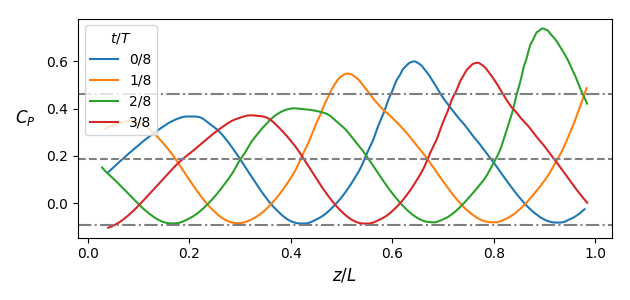

In [3]:
from scipy import signal
def low_pass(sr,dt=10,Hz=100):
    'Apply lowpass filter to a data series'
    win=signal.hann(int(Hz*dt)+1)
    pad = np.zeros(len(win)//2) * np.NaN
    sig = signal.convolve(sr, win, mode='valid')/ sum(win)
    return pd.Series(np.r_[pad,sig,pad])

def read_power(folder):
    df = pd.read_csv(folder+'/fort.9',delim_whitespace = True,
                        names=["time","CFL","power","phi"])
    df.drop(df.index[:3], inplace=True)
    df['power_smooth'] = low_pass(df.power,dt=0.03,Hz=len(df.power))
    df.Theta = 0.14
    return df

def average(df,var):
    return np.trapz(df[var],df.time)/(df.time.iloc[-1]-df.time.iloc[0])

plt.figure(figsize=(6.3,3),dpi=100)
plt.xlabel(r'$z/L$', fontsize=12)
plt.ylabel(r'$C_P$', rotation=0, labelpad=15,fontsize=12)

for i in range(4):
    folder = 'phase/case{:02d}'.format(i)
    df = read_power(folder)
    plt.plot(df.time,df.power_smooth/df.Theta**3,label=str(i)+'/8')

bar,amp = average(df,'power')/df.Theta**3,1.5748*df.power.mad()/df.Theta**3
plt.axhline(y=bar,color='grey',ls='--')
plt.axhline(y=bar+amp,color='grey',ls='-.')
plt.axhline(y=bar-amp,color='grey',ls='-.')

plt.legend(title=r'$t/T$')
plt.tight_layout()
plt.savefig('phase_Cp.png')
plt.show()

<IPython.core.display.Javascript object>


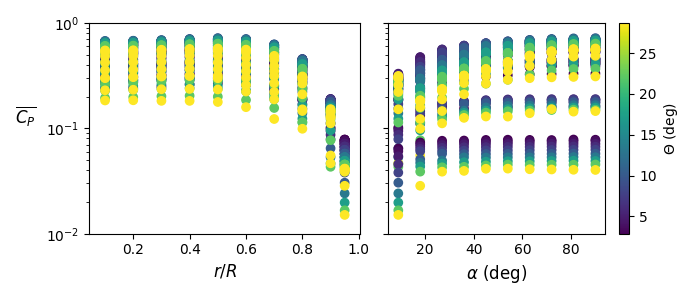

In [4]:
df = pd.read_csv('grid_out.csv').query('r<1')
df = pd.concat([df,pd.read_csv('grid_out_2.csv')])

fig,axa = plt.subplots(1,2,figsize=(7,3),dpi=100,sharey=True)
for ax in axa:
    ax.set_yscale('log')
    ax.set_ylim([1e-2,1])
axa[0].set_ylabel(r'$\overline{C_P}$', rotation=0, labelpad=15,fontsize=12)
axa[0].scatter(df.r,df.bar_p/df.Theta**3,c=180/np.pi*df.Theta)
axa[0].set_xlabel(r'$r/R$', fontsize=12)
im = axa[1].scatter(180/np.pi*df.alpha,df.bar_p/df.Theta**3,c=180/np.pi*df.Theta)
axa[1].set_xlabel(r'$\alpha$ (deg)', fontsize=12)
fig.colorbar(im,label=r'$\Theta$ (deg)')
plt.tight_layout()
plt.savefig('grid_bar_Cp.png')
plt.show()

<IPython.core.display.Javascript object>


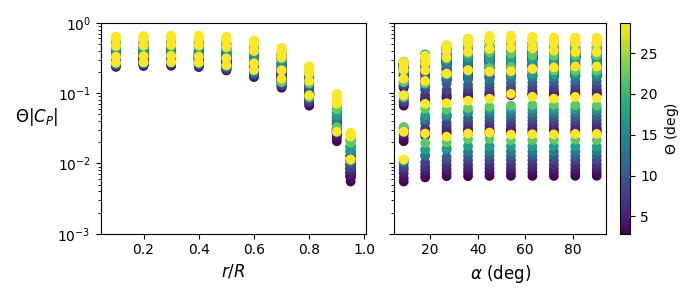

In [5]:
fig,axa = plt.subplots(1,2,figsize=(7,3),dpi=100,sharey=True)
for ax in axa:
    ax.set_yscale('log')
    ax.set_ylim([1e-3,1])
axa[0].set_ylabel(r'$\Theta |C_P|$', rotation=0, labelpad=15,fontsize=12)
axa[0].scatter(df.r,df.amp_p/df.Theta**2,c=180/np.pi*df.Theta)
axa[0].set_xlabel(r'$r/R$', fontsize=12)
im = axa[1].scatter(180/np.pi*df.alpha,df.amp_p/df.Theta**2,c=180/np.pi*df.Theta)
axa[1].set_xlabel(r'$\alpha$ (deg)', fontsize=12)
fig.colorbar(im,label=r'$\Theta$ (deg)')
plt.tight_layout()
plt.savefig('grid_amp_Cp.png')
plt.show()

<IPython.core.display.Javascript object>


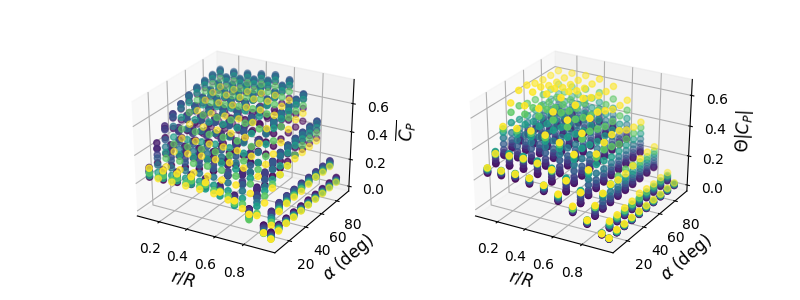

In [6]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,3),dpi=100)
ax = fig.add_subplot(121, projection='3d')
ax.scatter(df.r,180/np.pi*df.alpha,df.bar_p/df.Theta**3,c=180/np.pi*df.Theta)
ax.set_xlabel(r'$r/R$', fontsize=12)
ax.set_ylabel(r'$\alpha$ (deg)', fontsize=12)
ax.set_zlabel(r'$\overline{C_P}$', fontsize=12)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(df.r,180/np.pi*df.alpha,df.amp_p/df.Theta**2,c=180/np.pi*df.Theta)
ax.set_xlabel(r'$r/R$', fontsize=12)
ax.set_ylabel(r'$\alpha$ (deg)', fontsize=12)
ax.set_zlabel(r'$\Theta |C_P|$', fontsize=12)
plt.savefig('grid_3D_Cp.png')
plt.show()

1000 point model score:0.979277671025332
Intermediate model score:0.7930863781689311


<IPython.core.display.Javascript object>


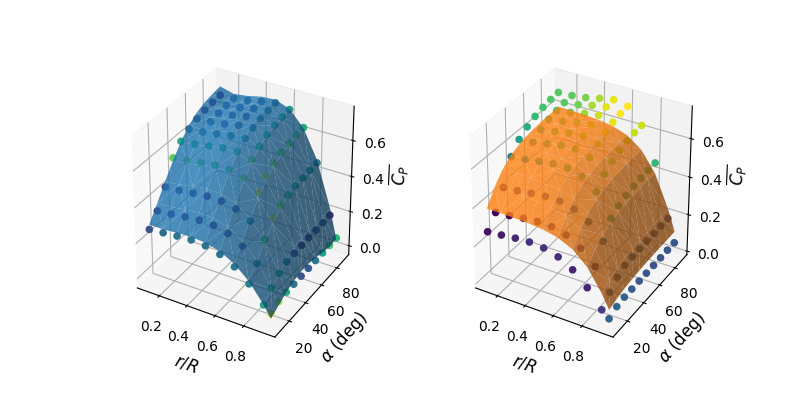

In [7]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ARDRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import explained_variance_score

# Pipeline
poly_model = make_pipeline(StandardScaler(),
                           PolynomialFeatures(4),
                           RidgeCV(cv=10))

# Model based on all the data
X = df[['Theta','alpha','r']]
y = df.bar_p/df.Theta**3
poly_model.fit(X, y)
score_1K = explained_variance_score(y,poly_model.predict(X))
print('1000 point model score:{}'.format(score_1K))

# Data slice
Theta_surf = df.Theta.unique()[5]
X_surf = df[df.Theta==Theta_surf][['Theta','alpha','r']]
y_dat = df[df.Theta==Theta_surf].bar_p/Theta_surf**3
y_fit = poly_model.predict(X_surf)

# Intermediate model
def IM(X): # X[0]=Theta, X[1]=alpha, X[2]=r
    return 0.3*(1+np.tanh(2*X[:,1]))*np.tanh(4*(1-X[:,2]))
y_IM = IM(X_surf.as_matrix())
score_IM = explained_variance_score(y,IM(X.as_matrix()))
print('Intermediate model score:{}'.format(score_IM))

# plot
fig = plt.figure(figsize=(8,4),dpi=100)
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(X_surf.r,180/np.pi*X_surf.alpha,y_fit,alpha=0.8)
ax.scatter(X_surf.r,180/np.pi*X_surf.alpha,y_dat,c=y_dat-y_fit,alpha=1)
ax.set_xlabel(r'$r/R$', fontsize=12)
ax.set_ylabel(r'$\alpha$ (deg)', fontsize=12)
ax.set_zlabel(r'$\overline{C_P}$', fontsize=12)

ax = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(X_surf.r,180/np.pi*X_surf.alpha,y_IM,color='C1',alpha=0.8)
ax.scatter(X_surf.r,180/np.pi*X_surf.alpha,y_dat,c=y_dat-y_IM,alpha=1)
ax.set_xlabel(r'$r/R$', fontsize=12)
ax.set_ylabel(r'$\alpha$ (deg)', fontsize=12)
ax.set_zlabel(r'$\overline{C_P}$', fontsize=12)
plt.savefig('surf_3D_Cp.png');

In [12]:
from sklearn.model_selection import train_test_split
warnings.simplefilter(action='ignore', category=(FutureWarning,DeprecationWarning))
from sklearn.preprocessing import FunctionTransformer

Create and evaluate the Polynomial Kernel Regression model

In [8]:
# Make the model "pipeline"
poly_model = make_pipeline(StandardScaler(),
                           PolynomialFeatures(4),
                           RidgeCV(cv=10))

# Evaulate model performance
def subfit(n,model,state=1): # split -> fit -> test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=state)
    model.fit(X_train, y_train)
    y_fit = model.predict(X_test)
    return {'score':explained_variance_score(y_test,y_fit),'n':n,'state':state}

def evaluate(model): # loop through the data set sizes
    return pd.DataFrame([subfit(n,model,state)
                         for n in np.logspace(1,2.466,20).astype(int)
                         for state in range(20)])

poly_results = evaluate(poly_model)

Create the PBLM model

In [9]:
# Hueristic model
def IM(X): # X[0]=Theta, X[1]=alpha, X[2]=r
    return 0.3*(1+np.tanh(2*X[:,1]))*np.tanh(4*(1-X[:,2]))

# Concatenate input
def transformer(X):
    return np.column_stack([X,IM(X)])

# PBLM pipeline
PBLM_model = make_pipeline(FunctionTransformer(transformer, validate=True),
                           StandardScaler(),
                           PolynomialFeatures(3),
                           RidgeCV(alphas=[1,10,100],cv=10))

PBLM_results = evaluate(PBLM_model)

<IPython.core.display.Javascript object>


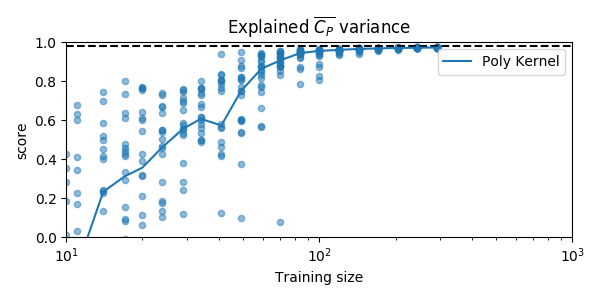

In [10]:
fig = plt.figure(figsize=(6,3),dpi=100)
ax = fig.add_subplot(111)
plt.axhline(y=score_1K,ls='--',c='k')
poly_results.plot.scatter(x='n',y='score',ax=ax,alpha=0.5)
poly_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,label='Poly Kernel')
# plt.axhline(y=0.54,ls='--',c='C1',label='Intermediate')
# PBLM_results.plot.scatter(x='n',y='score',ax=ax,c='C4',alpha=0.5)
# PBLM_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c='C4',label='Physics-based')

plt.ylim(0,1)
plt.xscale('log'); plt.xlim(10,1e3)
plt.legend()
plt.title('Explained $\overline{C_P}$ variance')
plt.xlabel('Training size')
plt.tight_layout()
plt.savefig('sadface.png')

<IPython.core.display.Javascript object>


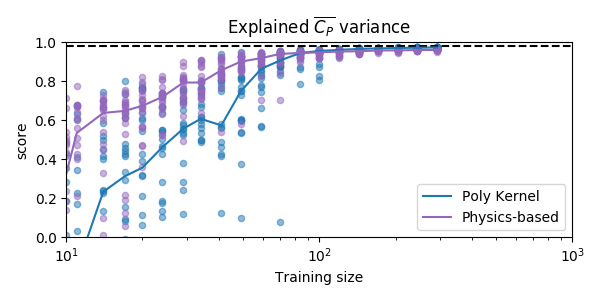

In [11]:
fig = plt.figure(figsize=(6,3),dpi=100)
ax = fig.add_subplot(111)
plt.axhline(y=score_1K,ls='--',c='k')
poly_results.plot.scatter(x='n',y='score',ax=ax,alpha=0.5)
poly_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,label='Poly Kernel')
# plt.axhline(y=0.54,ls='--',c='C1',label='Intermediate')
PBLM_results.plot.scatter(x='n',y='score',ax=ax,c='C4',alpha=0.5)
PBLM_results.groupby('n').median().reset_index().plot(x='n',y='score',ax=ax,c='C4',label='Physics-based')

plt.ylim(0,1)
plt.xscale('log'); plt.xlim(10,1e3)
plt.legend()
plt.title('Explained $\overline{C_P}$ variance')
plt.xlabel('Training size')
plt.tight_layout()
plt.savefig('tada1.png')

In [ ]:
# def DIM(X,i=None,dx=1e-2):
#     if i is None:
#         return np.column_stack([DIM(X,i,dx) for i in range(X.shape[1])])
#     else:
#         Xp = X.copy(); Xp[:,i]+=dx
#         Xm = X.copy(); Xp[:,i]-=dx
#         return (IM(Xp)-IM(Xm))/(2*dx)